Yuhan Chen dsci552
3009389875

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import sys
import csv
import seaborn as sns
import imblearn
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import f_regression
import statsmodels.discrete.discrete_model as sm
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install bootstrapped
!pip install imbalanced-learn

In [4]:
# Loading data for the 7 folders
data_dict = {}
sniffer = csv.Sniffer()
colname = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
directory = os.listdir("../data/AReM")
folders = [item for item in directory if '.' not in item]
for folder in folders:
    file_dir = "../data/AReM" + "/" + folder 
    files = [item for item in sorted(os.listdir(file_dir)) ]
#     print(files)
    for file in files:
        file_path = file_dir + "/" + file
#         print(file_path)
        with open(file_path, 'r') as csvfile:
            s = csvfile.read(500)
            tmp = s.split("\n")
            dialect = csv.Sniffer().sniff(tmp[5])
            delimiter = dialect.delimiter
            lst = tmp[5].split(delimiter)
            if(len(lst)==7):
                data_dict[folder+"/"+file] = pd.read_csv(file_path, delimiter = delimiter, skiprows=5, names = colname)
            else:
                df = pd.read_csv(file_path, delimiter = delimiter, skiprows=5, header = None).iloc[: , :7]
                df.columns = colname
                data_dict[folder+"/"+file] = df
data_dict['bending1/dataset1.csv'].head()

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,39.25,0.43,22.75,0.43,33.75,1.3
1,250,39.25,0.43,23.00,0.00,33.00,0.0
2,500,39.25,0.43,23.25,0.43,33.00,0.0
3,750,39.50,0.50,23.00,0.71,33.00,0.0
4,1000,39.50,0.50,24.00,0.00,33.00,0.0


In [14]:
def getList(dict):
    return dict.keys()
def split(data, n):
    try:
        data = data.drop(['time'], axis = 1)
    except:
        data = data
        
    new_df = pd.DataFrame()
    col_names = list(data.columns[:])
    size = len(data)//n
    for i in range(n):
        new_name = []
        for name in col_names:
            tmp = name + "_" + str(i)
            new_name.append(tmp)
        tmp_df = data.loc[i*size : (i+1)*size -1 , : ]
        tmp_df.columns = new_name
        new_df = pd.concat([new_df, tmp_df.reset_index(drop = True)], axis = 1)
    return new_df

def sep_time_feature(data):
    try:
        data = data.drop(['time'], axis = 1)
    except:
        data = data
    col_names = []
    head_name = list(data.columns)
    col_num = len(data.columns)
    for i in range(col_num):
        name = head_name[i]
        col_names.append(name + '_min_' + str(i+1))
        col_names.append(name + '_max_' + str(i+1))
        col_names.append(name + '_mean_' + str(i+1))
        col_names.append(name + '_median_' + str(i+1))
        col_names.append(name + '_std_' + str(i+1))
        col_names.append(name + '_1st_quartile_' + str(i+1))
        col_names.append(name + '_3rd_quartile_' + str(i+1))
               
    stat = []
    for i in range(col_num):
        Min = min(data.iloc[:, i])
        Max = max(data.iloc[:, i])
        Mean = data.iloc[:, i].mean()
        Median = data.iloc[:, i].median()
        Std = data.iloc[:, i].std()
        q1 = data.iloc[:, i].quantile(0.25)
        q3 = data.iloc[:, i].quantile(0.75)
        
        stat.append(Min)
        stat.append(Max)
        stat.append(Mean)
        stat.append(Median)
        stat.append(Std)
        stat.append(q1)
        stat.append(q3)
    result = pd.DataFrame([stat], columns = col_names)
    return result
def time_feature(data):
    all_stat = pd.DataFrame()
    for df in data.values():
        tmp = sep_time_feature(df)
        all_stat = all_stat.append(tmp, ignore_index=True)
    all_stat['instance'] = list(range(1, len(data.keys())+1))
    all_stat.set_index('instance', inplace = True)
    return all_stat
def new_time_feature(data, n):
    all_stat = pd.DataFrame()
    for df in data.values():
        new_df = split(df,n)
        tmp = sep_time_feature(new_df)
        all_stat = all_stat.append(tmp, ignore_index=True)
    all_stat['instance'] = list(range(1, len(data.keys())+1))
    all_stat.set_index('instance', inplace = True)
    return all_stat
def binary_classify(ts_lst, head_name, key_list, training_df):
    features = []
    for i in ts_lst:
        name = head_name[i-1]
        features.append(name + '_max_' + str(i))
        features.append(name + '_median_' + str(i))
        features.append(name + '_std_' + str(i))
    b_idx = []
    n_idx = []
    for key in key_list:
        if 'bending' in key:
            b_idx.append(key_list.index(key))
        else:
            n_idx.append(key_list.index(key))
    td = training_df[features]
    b_df = td.iloc[b_idx]
    b_df['class'] = 1
    n_df = td.iloc[n_idx]
    n_df['class'] = 0
    tb_df = pd.concat([b_df, n_df])
    tb_df = tb_df.sort_values('instance')
    return tb_df
def getclass(df, l):
    getnum_list = list(range(1,6*l+1))
    head_name = list(split(data_dict['bending1/dataset1.csv'], l).columns[:])
    train_data = new_time_feature(df, l)
    train_key = list(df.keys())
    train_df = binary_classify(getnum_list, head_name, train_key, train_data)
    return train_df

In [28]:
test_dict = {}
train_dict = {}
keys = list(data_dict)
test_keys = []
for key in keys:
    if "bending1" in key or "bending2" in key:
        if "dataset1" in key or "dataset2" in key:
            test_keys.append(key)
    else:
        for d in ["dataset1", "dataset2", "dataset3"]:        
            if key.split("/")[1].split(".")[0] == d:
                test_keys.append(key)
                
for key, val in data_dict.items():
    if key in test_keys:
        test_dict[key] = val
    else:
        train_dict[key] = val
def get_class_test(df,l):
    test_list = list(range(1,6*3+1))
    test_key = list(df.keys())
    test_df = new_time_feature(df,l)
    head_name = list(split(data_dict['bending1/dataset1.csv'], l).columns[:])
    helper = binary_classify(test_list, head_name, test_key,test_df)
    return helper
def get_feature_new_(tar_list,column_name):
    features = []
    for i in tar_list:
        name = column_name[i-1]
        features.append(name + '_max_' + str(i))
        features.append(name + '_median_' + str(i))
        features.append(name + '_std_' + str(i))
    return features

In [7]:
#----

In [8]:
training_df = time_feature(train_dict)
training_df

,avg_rss12_min_1,avg_rss12_max_1,avg_rss12_mean_1,avg_rss12_median_1,avg_rss12_std_1,avg_rss12_1st_quartile_1,avg_rss12_3rd_quartile_1,var_rss12_min_2,var_rss12_max_2,var_rss12_mean_2,...,avg_rss23_std_5,avg_rss23_1st_quartile_5,avg_rss23_3rd_quartile_5,var_rss23_min_6,var_rss23_max_6,var_rss23_mean_6,var_rss23_median_6,var_rss23_std_6,var_rss23_1st_quartile_6,var_rss23_3rd_quartile_6
instance,,,,,,,,,,,,,,,,,,,,,
1,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,1.999604,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.9400
2,33.00,47.75,42.179813,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000
3,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000
4,37.00,48.00,43.454958,43.25,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,2.488862,22.2500,24.00,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700
5,36.25,48.00,43.969125,44.50,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,3.318301,20.5000,23.75,0.0,2.96,0.555313,0.490,0.487826,0.0000,0.8300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,26.50,44.33,36.687292,36.00,3.529404,34.25,39.3725,0.0,12.89,2.973042,...,2.978238,14.6700,18.50,0.0,8.19,3.073312,2.690,1.629675,1.9125,4.0875
66,25.33,45.00,37.114312,36.25,3.710385,34.50,40.2500,0.0,10.84,2.730000,...,2.847876,14.7500,18.50,0.0,9.50,3.076354,2.770,1.824534,1.7000,4.0375
67,26.75,44.75,36.863375,36.33,3.555787,34.50,39.7500,0.0,11.68,2.757312,...,2.655906,15.0000,18.67,0.0,8.81,2.773312,2.590,1.569919,1.6400,3.6325


In [9]:
tb_df = binary_classify([1,2,6], list(data_dict['bending1/dataset1.csv'].columns[1:]), list(train_dict.keys()), training_df)

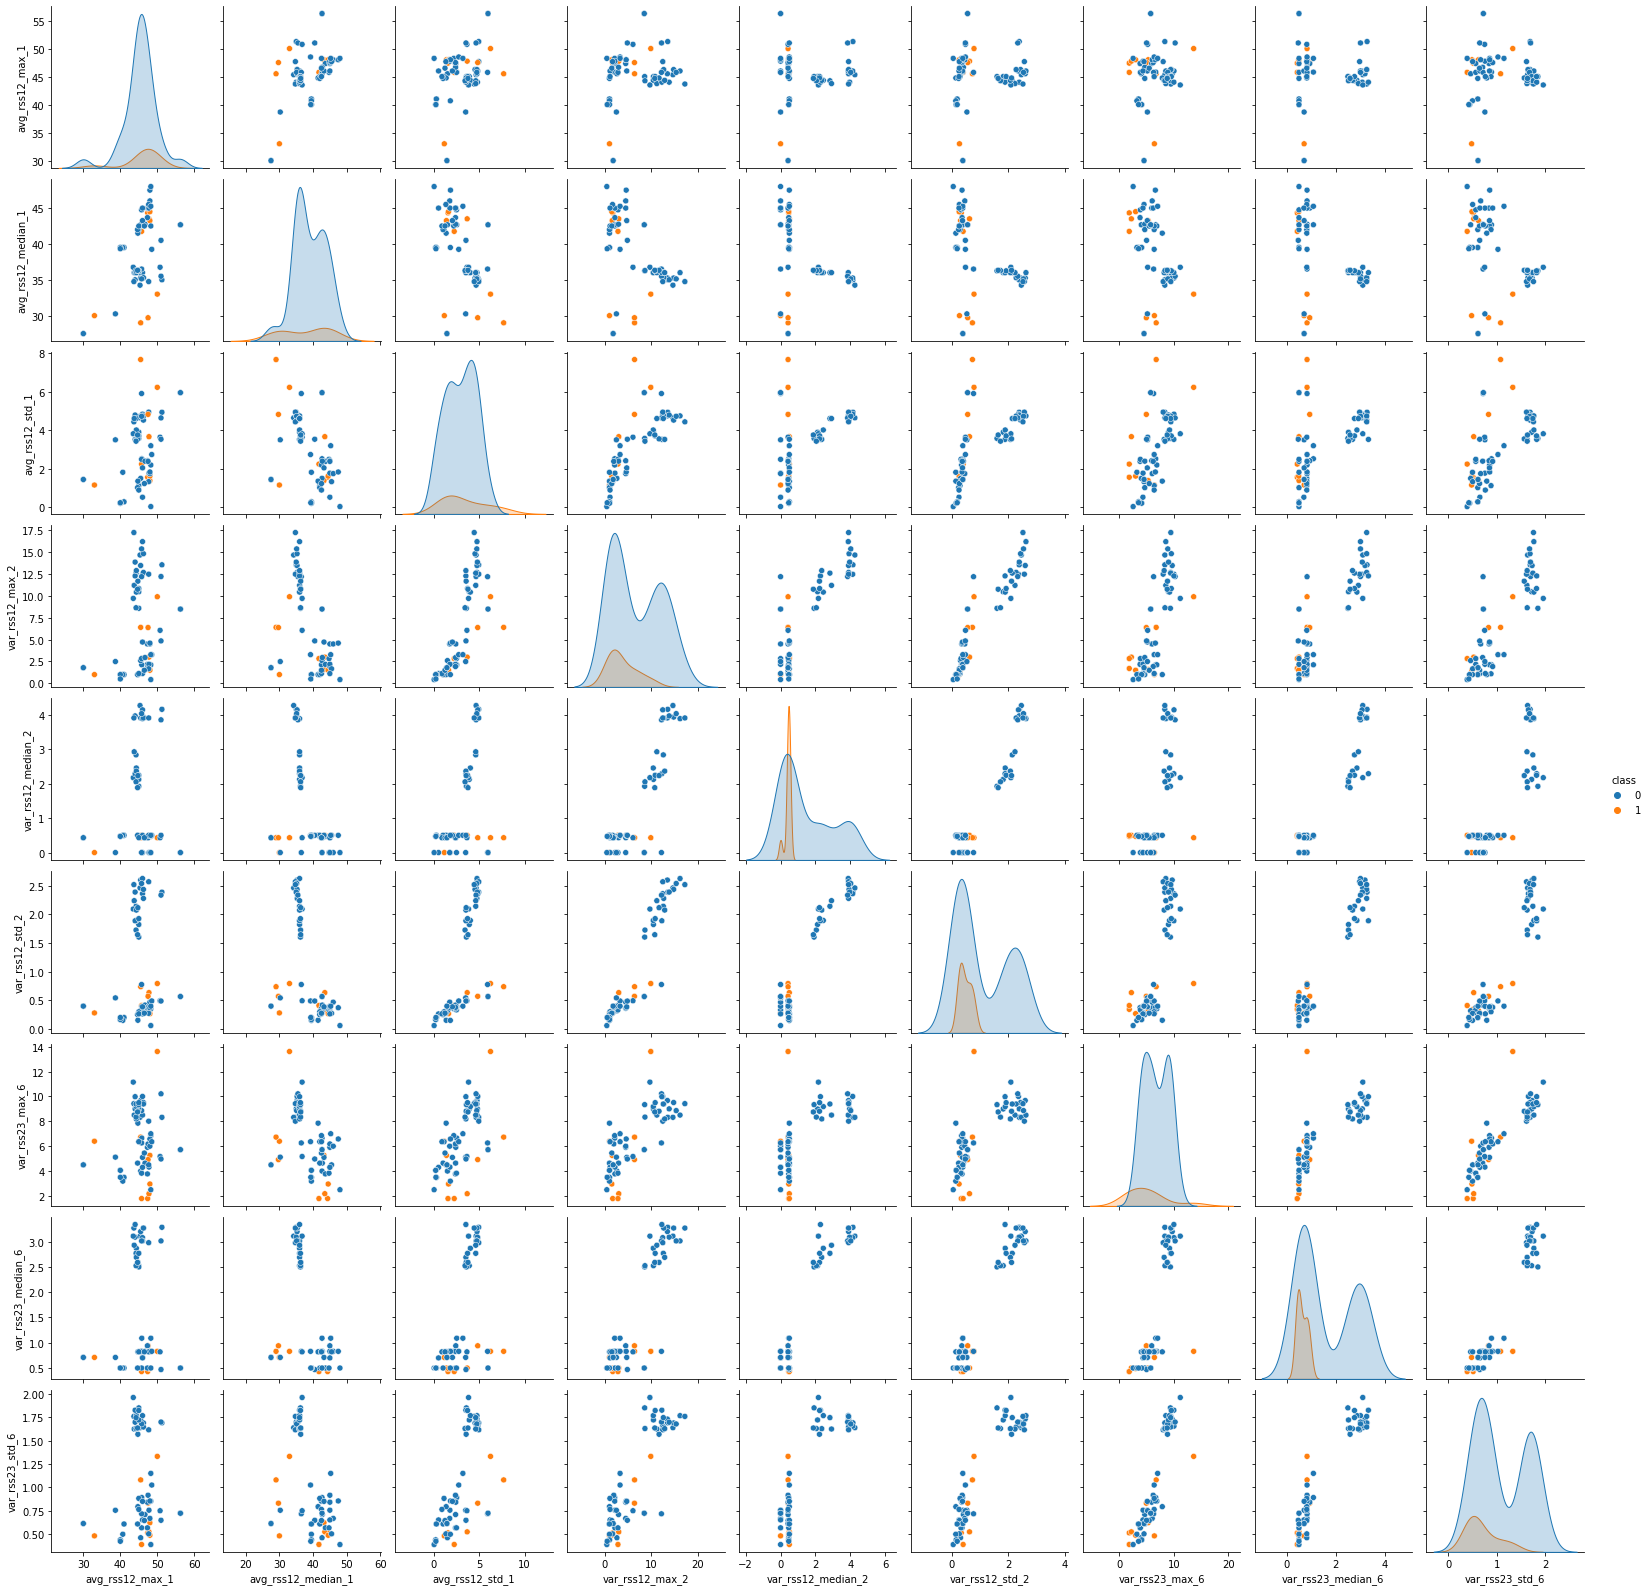

In [10]:
sns.pairplot(tb_df, hue="class")
plt.show()

In [15]:
new_training_df = new_time_feature(train_dict,2)
h_name = list(split(data_dict['bending1/dataset1.csv'],2).columns[:])
k_list = list(train_dict.keys())
new_tb_df = binary_classify([1,2,6,7,8,12], h_name, k_list,new_training_df)

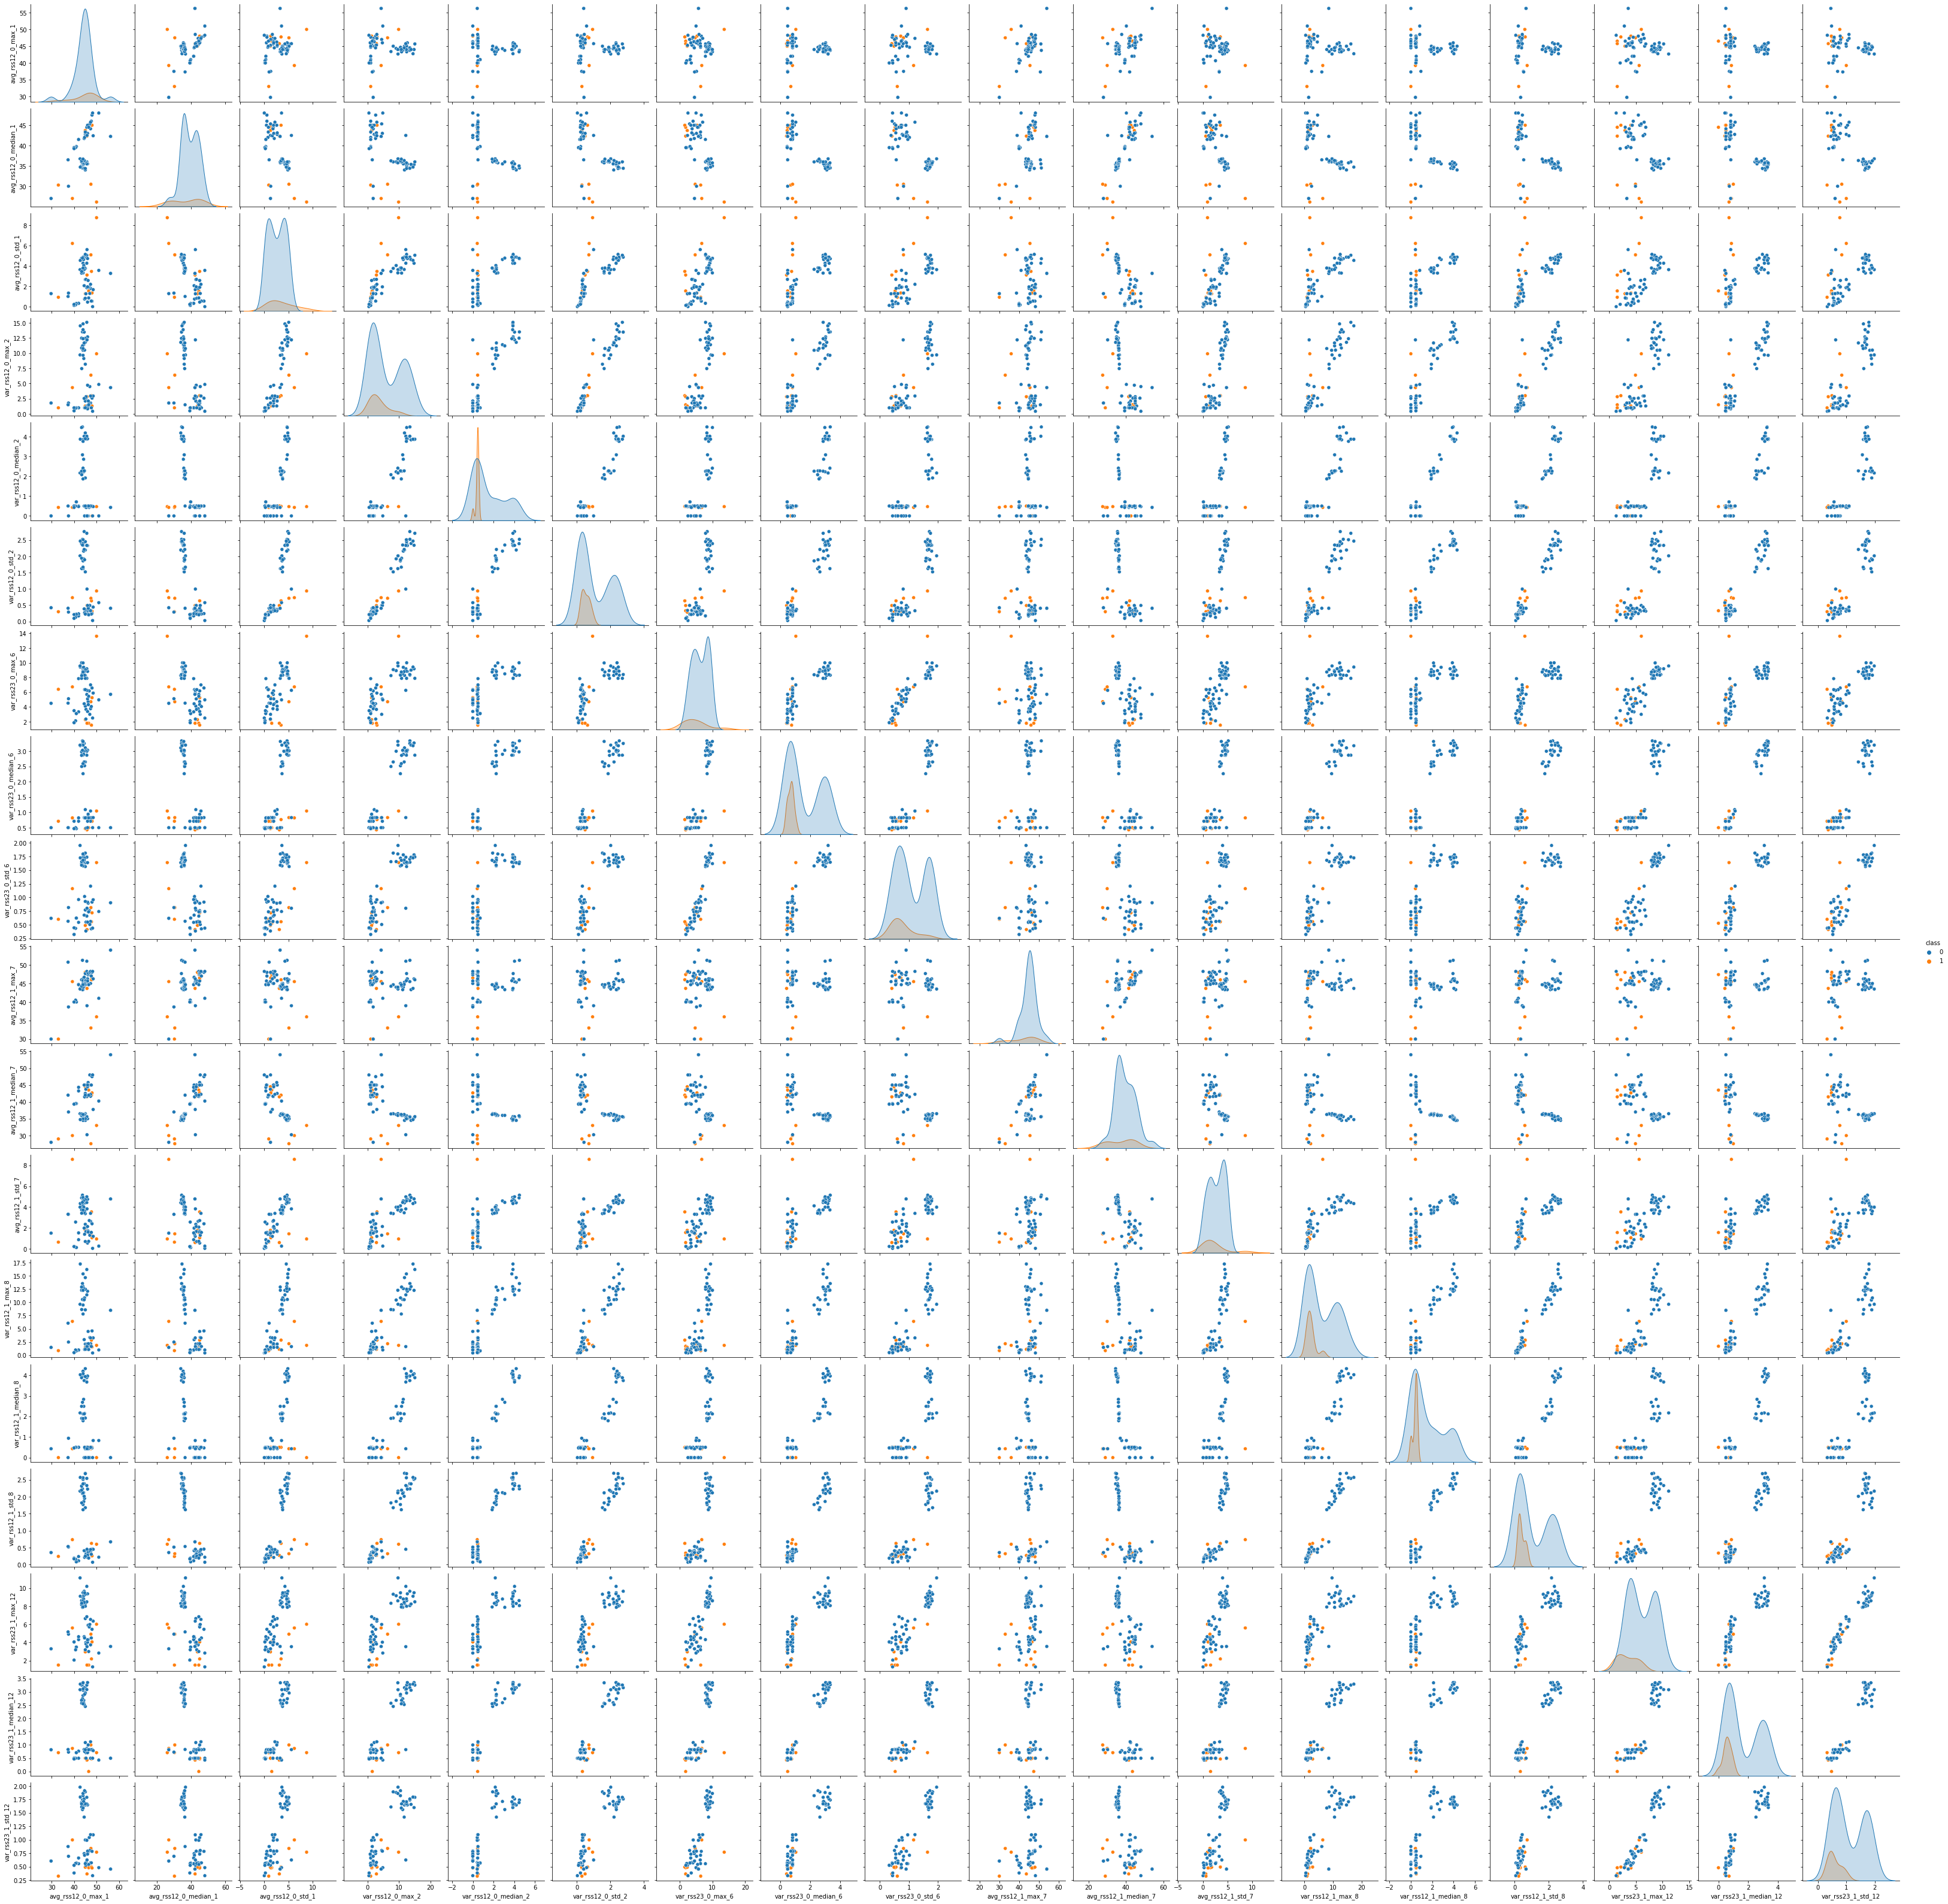

In [16]:
sns.pairplot(new_tb_df, hue="class")
plt.show()

iii.Break each time series in your training set into l ∈ {1,2, . . . ,20}time series of approximately equal length and use logistic regression5 to solve the binary
classification problem, using time-domain features

In [17]:
train_df.columns

NameError: name 'train_df' is not defined

In [18]:
score_list = []
pair_features = []

for l in range(1,21):
    train_df = getclass(train_dict, l)
    train_x = train_df.iloc[:,:-1]
    train_y = train_df['class']
    m = LogisticRegression(max_iter=10000)
    rfe = RFECV(estimator= m, cv = StratifiedKFold(n_splits=5) , step=1, scoring = 'accuracy')
    rfe = rfe.fit(train_x, train_y)
    cv_scor= rfe.grid_scores_[rfe.n_features_-1]
    cv_score = sum(cv_scor)/len(cv_scor)
    score_list.append(cv_score)
    pair_features.append(train_x.columns[rfe.support_])
    print('l = {}, p={}, cv accuracy={}'.format(l,rfe.n_features_,cv_score))

l = 1, p=4, cv accuracy=0.9714285714285715
l = 2, p=6, cv accuracy=0.9714285714285715
l = 3, p=1, cv accuracy=0.9857142857142858
l = 4, p=5, cv accuracy=0.9714285714285715
l = 5, p=5, cv accuracy=0.9714285714285715
l = 6, p=6, cv accuracy=0.9714285714285715
l = 7, p=9, cv accuracy=0.9714285714285715
l = 8, p=4, cv accuracy=0.9714285714285715
l = 9, p=5, cv accuracy=0.9714285714285715
l = 10, p=12, cv accuracy=0.9571428571428573
l = 11, p=15, cv accuracy=0.9714285714285715
l = 12, p=7, cv accuracy=0.9714285714285715
l = 13, p=8, cv accuracy=0.9714285714285715
l = 14, p=11, cv accuracy=0.9714285714285715
l = 15, p=13, cv accuracy=0.9571428571428573
l = 16, p=10, cv accuracy=0.9714285714285715
l = 17, p=9, cv accuracy=0.9571428571428573
l = 18, p=13, cv accuracy=0.9714285714285715
l = 19, p=14, cv accuracy=0.9571428571428573
l = 20, p=1, cv accuracy=0.9714285714285715


iv: Report the confusion matrix and show the ROC and AUC for your classifier
on train data. Report the parameters of your logistic regressionβi’s as well as the p-values associated with them.

l=3 gain highest score

In [19]:
import statsmodels.discrete.discrete_model as sm
from sklearn.linear_model import LogisticRegression

train_df = getclass(train_dict,3)
train_x = train_df[pair_features[2]]
train_y = train_df.iloc[:,-1:]
m = LogisticRegression()
m.fit(train_x, train_y)
y_pred=m.predict(train_x)
y_train=train_df.iloc[:,-1:]
y_train=y_train.values.reshape(-1,1)
train_x=train_x.values.reshape(-1,1)
model=sm.Logit(y_train,train_x)
model_fit=model.fit_regularized(maxiter=10000)
model_fit.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5050807687252675
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       68
Method:                           MLE   Df Model:                            0
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                 -0.3044
Time:                        21:42:03   Log-Likelihood:                -34.851
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0604      0.014     -4.457      0.000      -0.087      -0.034
==============================================================================
"""

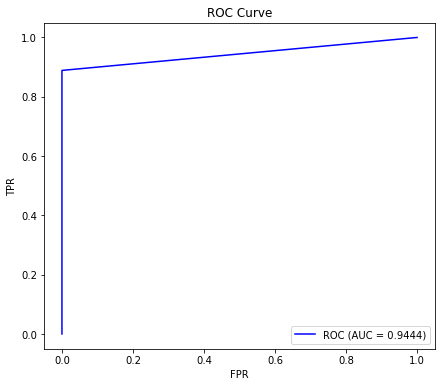

array([[60,  0],
       [ 1,  8]])

In [20]:
fpr, tpr, _ = roc_curve(train_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue',
         label='ROC (AUC = %0.4f)' % (roc_auc))
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
confusion_matrix(train_y, y_pred)

v. Test the classifier on the test set. Remember to break the time series in
your test set into the same number of time series into which you broke your
training set. Remember that the classifier has to be tested using the features
extracted from the test set. Compare the accuracy on the test set with the
cross-validation accuracy you obtained previously.

In [21]:
testdf = get_class_test(test_dict,3) 
test_x = testdf[pair_features[2]]
test_y = testdf.iloc[:,-1:]
m.score(test_x, test_y)

0.8947368421052632

vi.Do your classes seem to be well-separated to cause instability in calculating
logistic regression parameters?
A: Yes

vii: From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model

In [22]:
! pip install imblearn 
from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE

In [23]:
counter = Counter(train_y)
oversample = SMOTE(k_neighbors=3)
x,y= oversample.fit_resample(train_x,train_y)
model=LogisticRegression(max_iter=10000)
model.fit(x,y)
y_pred=model.predict(x)
confusion_matrix(y,y_pred)

array([[57,  3],
       [ 5, 55]])

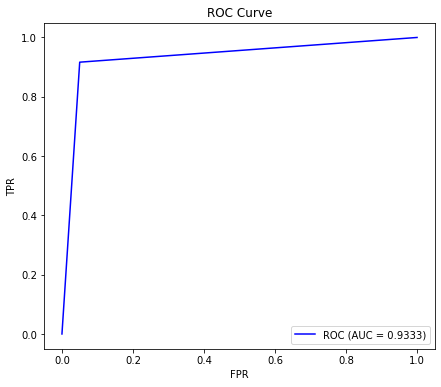

array([[57,  3],
       [ 5, 55]])

In [24]:

fpr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue',
         label='ROC (AUC = %0.4f)' % (roc_auc))
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
confusion_matrix(y, y_pred)

(b)Binary Classification Using L1-penalized logistic regression

In [25]:
score_list2 = []
for l in range(1,21):
    train_df = getclass(train_dict,l)
    train_x = train_df.iloc[:,:-1]
    train_y = train_df.iloc[:,-1:]
    model = LogisticRegressionCV(max_iter=10000,cv=StratifiedKFold(5), penalty="l1", solver="liblinear")
    model.fit(train_x, train_y)
    score = model.score(train_x, train_y)
    score_list2.append(score)
    print('l == {} cross_validation score is {}'.format(l, score))

l == 1 cross_validation score is 0.9855072463768116
l == 2 cross_validation score is 1.0
l == 3 cross_validation score is 1.0
l == 4 cross_validation score is 1.0
l == 5 cross_validation score is 1.0
l == 6 cross_validation score is 1.0
l == 7 cross_validation score is 1.0
l == 8 cross_validation score is 1.0
l == 9 cross_validation score is 1.0
l == 10 cross_validation score is 1.0
l == 11 cross_validation score is 1.0
l == 12 cross_validation score is 1.0
l == 13 cross_validation score is 1.0
l == 14 cross_validation score is 1.0
l == 15 cross_validation score is 1.0
l == 16 cross_validation score is 1.0
l == 17 cross_validation score is 1.0
l == 18 cross_validation score is 1.0
l == 19 cross_validation score is 1.0
l == 20 cross_validation score is 1.0


ii.Compare the L1-penalized with variable selection using p-values. Which one
performs better? Which one is easier to implement?

A: L1 yield a better cv score in avg therefore perform better

In [26]:
def multi_classify(ts_lst, head_name, key_list, training_df):
    features = get_feature_new_(ts_lst,head_name)
    bending=[]
    cycling=[]
    lying=[]
    sitting=[]
    standing=[]
    walking=[]
    for key in key_list:
        if 'bending' in key:
            bending.append(key_list.index(key))
        elif 'cycling' in key:
            cycling.append(key_list.index(key))
        elif 'lying' in key:
            lying.append(key_list.index(key))
        elif 'sitting' in key:
            sitting.append(key_list.index(key))
        elif 'standing' in key:
            standing.append(key_list.index(key))
        else:
            walking.append(key_list.index(key))
    td = training_df[features]
    list = ['bending','cycling','lying','sitting','standing','walking']
    a = 1 
    bending_df = td.iloc[bending]
    cycling_df = td.iloc[cycling]
    lying_df = td.iloc[lying]
    sitting_df = td.iloc[sitting]
    standing_df = td.iloc[standing]
    walking_df = td.iloc[walking]
    bending_df['class'] = 1
    cycling_df['class'] = 2
    lying_df['class'] = 3
    sitting_df['class'] = 4
    standing_df['class'] = 5
    walking_df['class'] = 6
    total_df = pd.concat([bending_df, cycling_df,lying_df,sitting_df,standing_df,walking_df])
    total_df = total_df.sort_values('instance')
    return total_df

C. Find the bestlin the same way as you found it in 2(b)i to build anL1-penalized multinomial regression model to classify all activities in your train-ing set.10 Report your test error. Research how confusion matrices and ROC
curves are defined for multiclass classification and show them for this problem
if possible

In [29]:
train_list = []
test_list = []

def getclass_multi(df, l):
    getnum_list = list(range(1,6*l+1))
    head_name = list(split(data_dict['bending1/dataset1.csv'], l).columns[:])
    train_data = new_time_feature(df, l)
    train_key = list(df.keys())
    train_df_c = multi_classify(getnum_list, head_name, train_key,train_data)
    return train_df_c

for l in range(1,21):
    train_df = getclass_multi(train_dict,l)
    train_x = train_df.iloc[:,:-1]
    train_y = train_df.iloc[:,-1:]
    
    test_df = getclass_multi(test_dict,l)
    test_x = test_df.iloc[:,:-1]
    test_y = test_df.iloc[:,-1:]
    m = LogisticRegressionCV(cv=StratifiedKFold(5), multi_class = 'multinomial',penalty="l1", solver="saga")
    m = m.fit(train_x, train_y)
    train_score = m.score(train_x, train_y)
    train_list.append(train_score)
    test_score = m.score(test_x, test_y)
    test_error = 1 - test_score
    test_list.append(test_error)
    print('when l is {} the test error is {}'.format(l, test_error))

when l is 1 the test error is 0.10526315789473684
when l is 2 the test error is 0.10526315789473684
when l is 3 the test error is 0.21052631578947367
when l is 4 the test error is 0.10526315789473684
when l is 5 the test error is 0.1578947368421053
when l is 6 the test error is 0.10526315789473684
when l is 7 the test error is 0.10526315789473684
when l is 8 the test error is 0.10526315789473684
when l is 9 the test error is 0.10526315789473684
when l is 10 the test error is 0.10526315789473684
when l is 11 the test error is 0.052631578947368474
when l is 12 the test error is 0.052631578947368474
when l is 13 the test error is 0.10526315789473684
when l is 14 the test error is 0.052631578947368474
when l is 15 the test error is 0.1578947368421053
when l is 16 the test error is 0.10526315789473684
when l is 17 the test error is 0.1578947368421053
when l is 18 the test error is 0.21052631578947367
when l is 19 the test error is 0.10526315789473684
when l is 20 the test error is 0.1578947

 11 12 and 14 has the best outcome

In [30]:
data= getclass_multi(train_dict,11)
x_train=data.iloc[:,:-1]
y_train=data['class']
model=LogisticRegression(max_iter=10000)
model.fit(x_train,y_train)
y_pred=model.predict(x_train)
confusion_matrix(y_train,y_pred)

array([[ 9,  0,  0,  0,  0,  0],
       [ 0, 12,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0],
       [ 0,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0, 12]])

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

data= getclass_multi(test_dict,11)
y_test=data['class']
x_test=data.iloc[:,:-1]

my_train = label_binarize(y_train, classes=[1, 2, 3, 4, 5, 6])
num_classes = my_train.shape[1]
my_test = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6])
y_test = preprocessing.scale(my_test)
classifier = OneVsRestClassifier(LogisticRegressionCV(cv=StratifiedKFold(5), penalty="l1", solver="liblinear"))
classifier.fit(x_train, my_train)
y_score = classifier.decision_function(x_test)

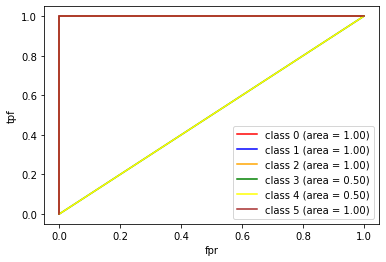

In [34]:
colors = ['red', 'blue', 'orange', 'green', 'yellow', 'brown']
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(my_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,color=colors[i],label="class {0} (area = {1:0.2f})".format(i, roc_auc))
    plt.xlabel('fpr')
    plt.ylabel('tpf')
    plt.legend()

Repeat 2(c)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi-
nomial priors and compare the results.

In [35]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [37]:
# for l in range(1,21):
#     train_df = getclass_multi(train_dict,l)
#     train_x = train_df.iloc[:,:-1]
#     train_y = train_df.iloc[:,-1:]
    
#     test_df = getclass_multi(test_dict,l)
#     test_x = test_df.iloc[:,:-1]
#     test_y = test_df.iloc[:,-1:]
#     m = LogisticRegressionCV(cv=StratifiedKFold(5), multi_class = 'multinomial',penalty="l1", solver="saga")
#     m = m.fit(train_x, train_y)
#     train_score = m.score(train_x, train_y)
#     train_list.append(train_score)
#     test_score = m.score(test_x, test_y)
#     test_error = 1 - test_score
#     test_list.append(test_error)
#     print('when l is {} the test error is {}'.format(l, test_error))



test_error_list2 = []
for l in range(1,21):
    data_train= getclass_multi(train_dict,l)
    train_x = data_train.iloc[:,:-1]
    train_y = data_train.iloc[:,-1:]
    
    data_test = getclass_multi(test_dict,l)
    test_x = data_test.iloc[:,:-1]
    test_y = data_test.iloc[:,-1:]
    
    model_g = GaussianNB()   
    model_g = model_g.fit(train_x, train_y)
    test_score = model_g.score(test_x, test_y)
    error = 1-test_score
    test_error_list2.append(error)
    print('l = {}, test error={}'.format(l,error))

l = 1, test error=0.052631578947368474
l = 2, test error=0.052631578947368474
l = 3, test error=0.10526315789473684
l = 4, test error=0.10526315789473684
l = 5, test error=0.10526315789473684
l = 6, test error=0.10526315789473684
l = 7, test error=0.1578947368421053
l = 8, test error=0.1578947368421053
l = 9, test error=0.10526315789473684
l = 10, test error=0.10526315789473684
l = 11, test error=0.1578947368421053
l = 12, test error=0.1578947368421053
l = 13, test error=0.1578947368421053
l = 14, test error=0.10526315789473684
l = 15, test error=0.1578947368421053
l = 16, test error=0.1578947368421053
l = 17, test error=0.1578947368421053
l = 18, test error=0.1578947368421053
l = 19, test error=0.10526315789473684
l = 20, test error=0.1578947368421053


In [38]:
a = sum(test_error_list2)/len(test_error_list2)
print(a)

0.12631578947368421


In [39]:
data= getclass_multi(train_dict,2)
x_train=data.iloc[:,:-1]
y_train=data['class']
model = GaussianNB() 
model.fit(x_train,y_train)
y_pred=model.predict(x_train)
confusion_matrix(y_train,y_pred)

array([[ 8,  0,  1,  0,  0,  0],
       [ 0, 12,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0],
       [ 0,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0, 12]])

In [40]:
test_error_list3 = []
for l in range(1,21):
    data_train= getclass_multi(train_dict,l)
    train_x = data_train.iloc[:,:-1]
    train_y = data_train.iloc[:,-1:]
    
    data_test = getclass_multi(test_dict,l)
    test_x = data_test.iloc[:,:-1]
    test_y = data_test.iloc[:,-1:]
    
    model2 = MultinomialNB()  
    model2 = model2.fit(train_x, train_y)
    test_score = model2.score(test_x, test_y)
    error=1-test_score 
    test_error_list3.append(error)
    print('l = {}, test error={}'.format(l,error))
print(sum(test_error_list3)/len(test_error_list3))

l = 1, test error=0.10526315789473684
l = 2, test error=0.1578947368421053
l = 3, test error=0.1578947368421053
l = 4, test error=0.10526315789473684
l = 5, test error=0.1578947368421053
l = 6, test error=0.1578947368421053
l = 7, test error=0.10526315789473684
l = 8, test error=0.1578947368421053
l = 9, test error=0.1578947368421053
l = 10, test error=0.052631578947368474
l = 11, test error=0.10526315789473684
l = 12, test error=0.10526315789473684
l = 13, test error=0.052631578947368474
l = 14, test error=0.10526315789473684
l = 15, test error=0.10526315789473684
l = 16, test error=0.052631578947368474
l = 17, test error=0.052631578947368474
l = 18, test error=0.052631578947368474
l = 19, test error=0.052631578947368474
l = 20, test error=0.052631578947368474
0.10263157894736848


In [41]:
data= getclass_multi(train_dict,10)
x_train=data.iloc[:,:-1]
y_train=data['class']
model2 = MultinomialNB() 
model2.fit(x_train,y_train)
y_pred=model2.predict(x_train)
confusion_matrix(y_train,y_pred)

array([[ 9,  0,  0,  0,  0,  0],
       [ 0, 12,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0],
       [ 1,  0,  0, 11,  0,  0],
       [ 0,  0,  0,  1, 11,  0],
       [ 0,  0,  0,  0,  0, 12]])

Which method is better for multi-class classification in this problem?

Multinomial has smaller test error in avg

check url:
    https://drive.google.com/drive/folders/1d6NhwljzOZ5MHRFnNWMVpIDNQVAvkmgL?usp=sharing